# Proyecto Regresión Logística

OBJETIVO: Predecir si un cliente contratará un depósito a largo plazo (variable 'y') 
basado en variables demográficas, financieras y de contacto del cliente.

CONTEXTO: Optimizar campañas de marketing identificando clientes con mayor probabilidad 
de contratación para reducir costos y aumentar eficiencia.

In [1]:
# LIBRERÍAS PARA REGRESIÓN LOGÍSTICA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

In [3]:
# CARGA DE DATOS - MARKETING BANCARIO
url = "https://storage.googleapis.com/breathecode/project-files/bank-marketing-campaign-data.csv"
df = pd.read_csv(url, sep=';')

# VISUALIZACIÓN INICIAL
print("DIMENSIONES DEL DATASET:", df.shape)
print("\nPRIMERAS FILAS:")
df.head()

DIMENSIONES DEL DATASET: (41188, 21)

PRIMERAS FILAS:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# INFO GENERAL DEL DATASET
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [5]:
# VERIFICACION DE NULOS
print("Valores nulos por columna:")
print(df.isnull().sum())

# VERIFICACION DE DUPLICADOS
print(f"Filas duplicadas: {df.duplicated().sum()}")

Valores nulos por columna:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64
Filas duplicadas: 12


Se detectan 12 filas duplicadas. La eliminamos para evitar sesgos en el modelo.

In [6]:
# ELIMINACIÓN DE DUPLICADOS

df = df.drop_duplicates()
print(f"Dataset después de eliminar duplicados: {df.shape}")

Dataset después de eliminar duplicados: (41176, 21)


In [8]:
# ANALISIS DE OUTLIERS CON IQR

numericas = df.select_dtypes(include=['int64', 'float64']).columns

for col in numericas:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")

age: 468 outliers (1.1%)
duration: 2963 outliers (7.2%)
campaign: 2406 outliers (5.8%)
pdays: 1515 outliers (3.7%)
previous: 5625 outliers (13.7%)
emp.var.rate: 0 outliers (0.0%)
cons.price.idx: 0 outliers (0.0%)
cons.conf.idx: 446 outliers (1.1%)
euribor3m: 0 outliers (0.0%)
nr.employed: 0 outliers (0.0%)


Se detectan outliers significativos en variables clave como duration (7.2%), campaign (5.8%) y previous (13.7%). Para fines didácticos y mejorar la calidad del modelo, procederemos a eliminar los outliers superiores extremos.

In [9]:
# ELIMINACIÓN DE OUTLIERS SUPERIORES EXTREMOS
df_clean = df.copy()

for col in ['duration', 'campaign', 'previous']:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR
    
    filas_antes = len(df_clean)
    df_clean = df_clean[df_clean[col] <= limite_superior]
    filas_eliminadas = filas_antes - len(df_clean)
    print(f"{col}: eliminadas {filas_eliminadas} filas")

print(f"\nDataset final: {len(df_clean)} filas ({len(df) - len(df_clean)} eliminadas)")

duration: eliminadas 2963 filas
campaign: eliminadas 2262 filas
previous: eliminadas 5143 filas

Dataset final: 30808 filas (10368 eliminadas)


VARIABLE TARGET (y):
y
no     36537
yes     4639
Name: count, dtype: int64
y
no     0.887337
yes    0.112663
Name: proportion, dtype: float64


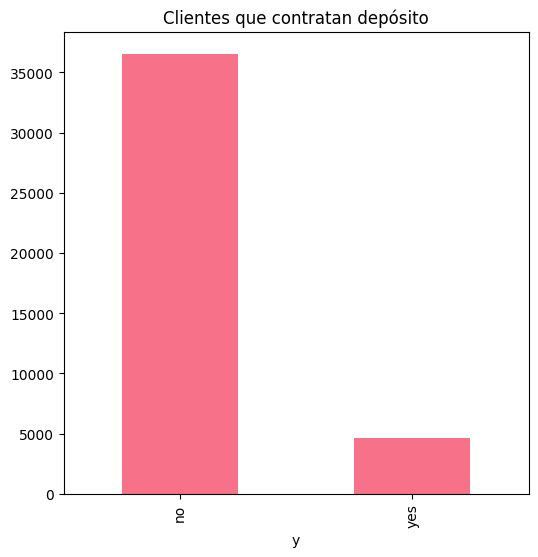

In [13]:
# VARIABLE TARGET
print("VARIABLE TARGET (y):")
print(df['y'].value_counts())
print(df['y'].value_counts(normalize=True))

plt.figure(figsize=(6,6))
df['y'].value_counts().plot(kind='bar')
plt.title('Clientes que contratan depósito')
plt.show()

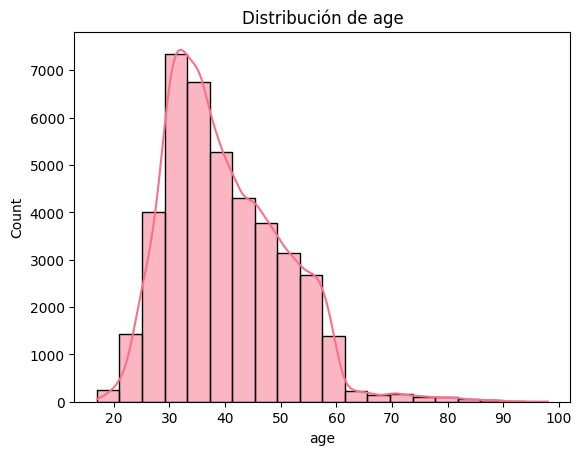

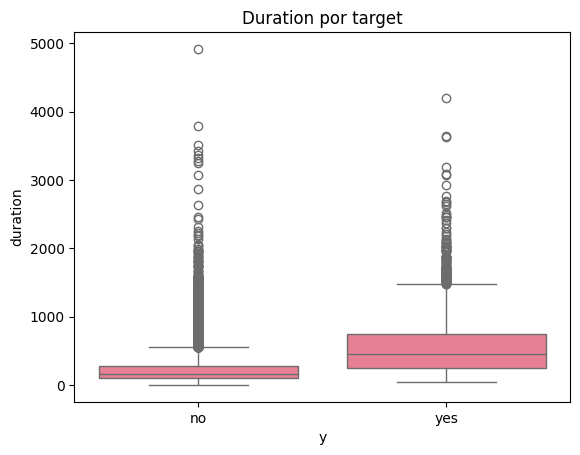

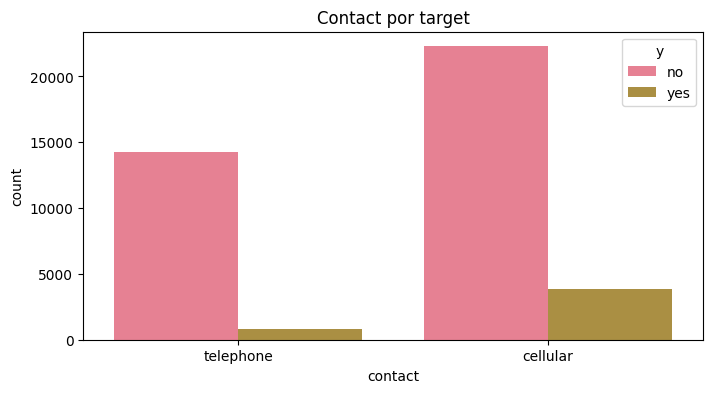

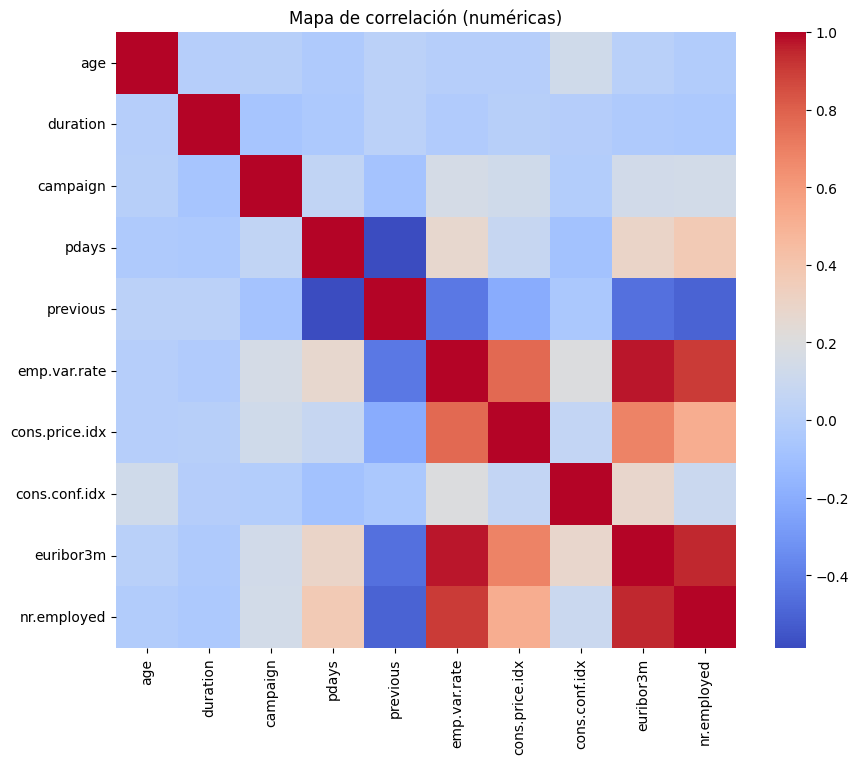

In [21]:
# 6. ANÁLISIS EXPLORATORIO (EDA) - DISTRIBUCIONES Y RELACIONES

# DISTRIBUCIÓN DE AGE
plt.figure()
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Distribución de age')
plt.show()

# DURATION VS TARGET (BOXPLOT)
plt.figure()
sns.boxplot(x='y', y='duration', data=df)
plt.title('Duration por target')
plt.show()

# CONTACT POR RESULTADO
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='contact', hue='y')
plt.title('Contact por target')
plt.show()

# CORRELACIÓN ENTRE VARIABLES NUMÉRICAS
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', annot=False)
plt.title('Mapa de correlación (numéricas)')
plt.show()
